In [1]:
import anndata as ad
import numpy as np
import spateo as st

2024-08-11 20:20:47.430526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behav

## Load anndata object

In [3]:
adata = ad.read(f"/media/pc001/Yao/Projects/Project_spateo/mouse_heart/figure1/embryo_h5ad/Mouse_E9.5_full_data.h5ad")
adata

AnnData object with n_obs × n_vars = 646893 × 17649
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'transf_anno_E95', 'mapped_celltype', 'head_or_body', 'heart_region'
    obsm: '3d_align_spatial', 'X_pca', 'bbox', 'global_align_spatial', 'spatial'

## Update anndata object

In [4]:
import scanpy as sc
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
adata = adata[adata.X.sum(axis=1) != 0, adata.X.sum(axis=0) != 0]
adata

View of AnnData object with n_obs × n_vars = 646893 × 2000
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'transf_anno_E95', 'mapped_celltype', 'head_or_body', 'heart_region'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: '3d_align_spatial', 'X_pca', 'bbox', 'global_align_spatial', 'spatial'

In [5]:
from scipy import sparse
for matrix_id in ["X"]:
        matrix = adata.X if matrix_id == "X" else adata.layers[matrix_id]
        matrix = matrix.astype(int)
        sparse.save_npz(f"/home/pc001/BioProjects/Packages/spateo-viewer/stviewer/assets/dataset/mouse_E95/matrices/{matrix_id}_sparse_martrix.npz", matrix)

In [6]:
cleanup_adata = adata.copy()
del cleanup_adata.obsm, cleanup_adata.var, cleanup_adata.uns
cleanup_adata.X = None
cleanup_adata.obs = cleanup_adata.obs[['area', 'transf_anno_E95', 'mapped_celltype', 'head_or_body', 'heart_region']]
cleanup_adata.obsm['spatial'] = adata.obsm['3d_align_spatial']
cleanup_adata.write_h5ad(f"/home/pc001/BioProjects/Packages/spateo-viewer/stviewer/assets/dataset/mouse_E95/h5ad/mouse_E95.h5ad", compression="gzip")
cleanup_adata

AnnData object with n_obs × n_vars = 646893 × 2000
    obs: 'area', 'transf_anno_E95', 'mapped_celltype', 'head_or_body', 'heart_region'
    obsm: 'spatial'

## Construct pc model

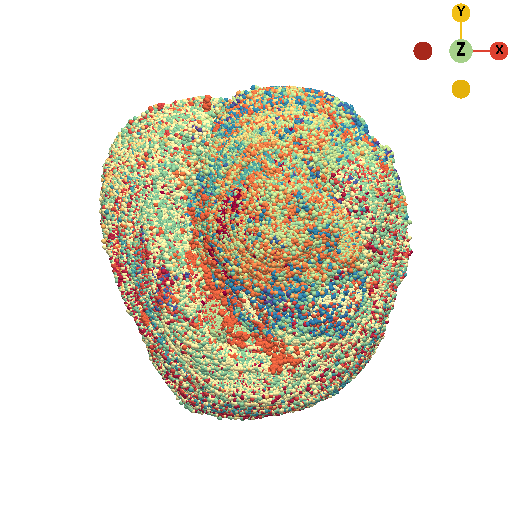

In [8]:
pc_model, _ = st.tdr.construct_pc(adata=cleanup_adata, spatial_key='spatial',groupby='mapped_celltype',key_added='mapped_celltype', colormap='Spectral_r')
st.pl.three_d_plot(model=pc_model, key='mapped_celltype', model_style="points", model_size=5, jupyter="static", cpo="xy")
st.tdr.save_model(pc_model, f"/home/pc001/BioProjects/Packages/spateo-viewer/stviewer/assets/dataset/mouse_E95/pc_models/0_Embryo_mouse_E95_pc_model.vtk")

## Construct mesh model

In [10]:
if pc_model.n_points > 100000:
        np.random.seed(19491001)
        sampling = np.random.choice(
            np.asarray(pc_model.point_data["obs_index"]),
            size=50000,
            replace=False,
        )
        _pc_model = pc_model.extract_points(
            np.isin(np.asarray(pc_model.point_data["obs_index"]), sampling)
        )
else:
    _pc_model = pc_model.copy()

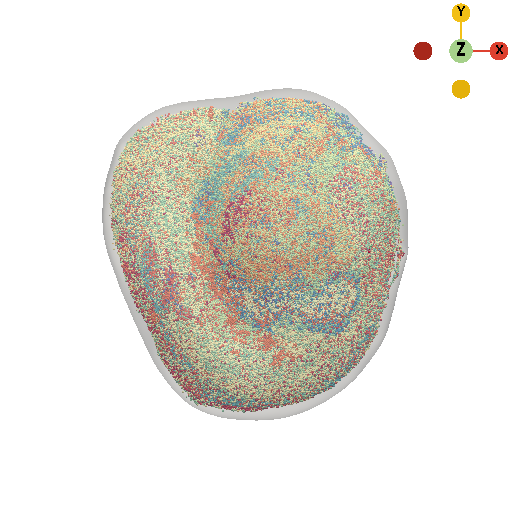

In [11]:
mesh_model, _, _ = st.tdr.construct_surface(
    pc=_pc_model,
    key_added='mapped_celltype',
    label="embryo_shell",
    color="gainsboro",
    alpha=1,
    cs_method="marching_cube",
    cs_args={"mc_scale_factor": 1, 'dist_sample_num': None},
    smooth=10000,
    scale_factor=1.04,
)
_ = st.pl.three_d_plot(model=st.tdr.collect_models([pc_model, mesh_model]), key='mapped_celltype', model_style=["points", "surface"], model_size=2, opacity=[1, 0.4], cpo="xy", jupyter='static')
st.tdr.save_model(mesh_model, f"/home/pc001/BioProjects/Packages/spateo-viewer/stviewer/assets/dataset/mouse_E95/mesh_models/0_Embryo_mouse_E95_mesh_model.vtk")